# Simulation de Dépacement 2D - 2

In [23]:
import numpy as np
import numpy.linalg as nplin
from scipy.integrate import odeint, solve_ivp

from IPython.display import Image

Ce notebook simule le déplacement d'un floe isolé en 2D par les fonctions de bibliothèque de Scipy. Les détails de la modélisation sont dans le rapport de stage.

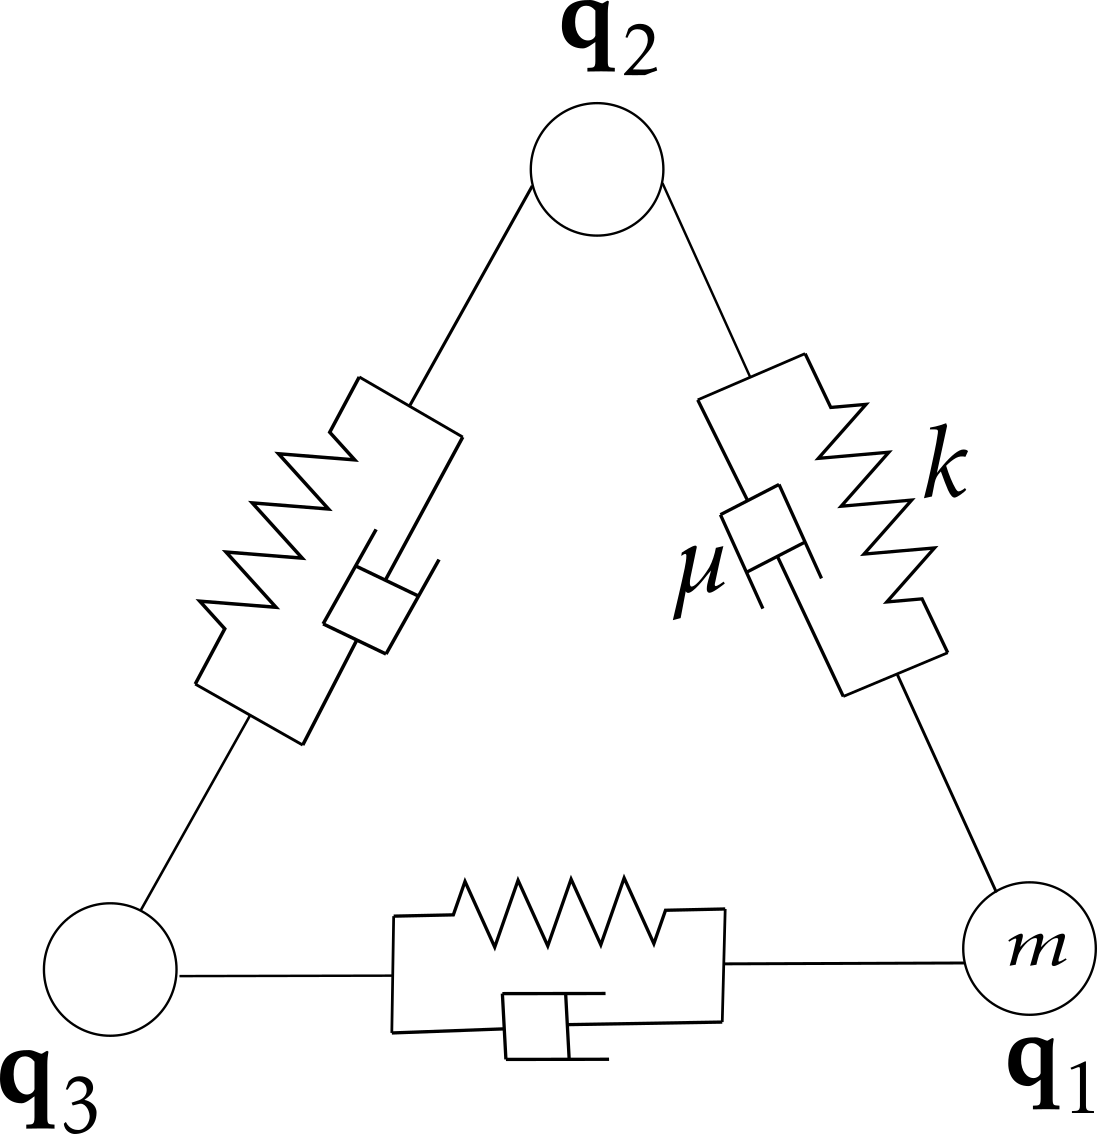

In [24]:
Image("../../reports/internship/Figures/Deplacement2D-1.png", width=300)

Le système est régi par les équations suivantes:
$$
\forall i \in \mathbb{Z}/3\mathbb{Z}, \quad m \ddot{\textbf{q}}_i = \sum_{j=i+1}^{i+2}C_{ij} \left[  k \left( \Vert \textbf{q}_j - \textbf{q}_i \Vert - L_{ij} \right) \textbf{u}_{ij} - \mu \left\langle \dot{\textbf{q}}_j - \dot{\textbf{q}}_i, \, \textbf{u}_{ij}  \right\rangle  \textbf{u}_{ij} \right]
$$

## Interactive plot

Observons un plot interactif dans lesquel on pourra faire varier les paramètres du modèle. Il faudra installer le package [Bokeh](https://bokeh.org/) en plus de matplotlib pour que ca fonctionne.

In [25]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, ConnectionPatch
from matplotlib.collections import PatchCollection

from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [26]:
## Des fonction pour le dessin du réseau

def makeScene(nbAx=1):                         ## Pour faire des plots en horizontale
    fig, ax = plt.subplots(1, nbAx, figsize=(6.4*nbAx, 4.8))
    if nbAx == 1:
      ax.set_xlim([-1,1])
      ax.set_ylim([-1,1])
      ax.set_aspect('equal', adjustable='box')
    else:
      for axis in ax:
        axis.set_xlim([-1,1])
        axis.set_ylim([-1,1])
        axis.set_aspect('equal', adjustable='box');
    return ax

ax = makeScene(2);
def update_axis(ax, q1, q2, q3, title="Positions"):
    ax.add_patch(Circle(q1, radius=0.1, alpha=0.5, fc=(1,0.1,0.1), ec='k'));
    ax.add_patch(Circle(q2, radius=0.1, alpha=0.5, fc=(0.1,1,0.1), ec='k'));
    ax.add_patch(Circle(q3, radius=0.1, alpha=0.5, fc=(0.1,0.1,1), ec='k'));

    ax.add_artist(ConnectionPatch(xyA = q1, coordsA = ax.transData, xyB = q2, coordsB = ax.transData, arrowstyle ="-"))
    ax.add_artist(ConnectionPatch(xyA = q2, coordsA = ax.transData, xyB = q3, coordsB = ax.transData, arrowstyle ="-"))
    ax.add_artist(ConnectionPatch(xyA = q1, coordsA = ax.transData, xyB = q3, coordsB = ax.transData, arrowstyle ="-"))
    
    ax.set_title(title)

# update_axis(ax[0], q1_0, q2_0, q3_0)
# update_axis(ax[1], q1_f, q2_f, q3_f)
plt.close()

In [27]:
## Nombre de noeuds
nb_nodes = 3

N = 5000
T = 4.0
dt = T/N
t = np.linspace(0,T, N+1)
q = np.zeros(shape=(nb_nodes, N+1, 2))

p = figure(title="Plot des positions des noeuds",
           plot_height=500, plot_width=1000, y_range=(-1,1),background_fill_color='#efefef')

q1x = p.line(t, q[0,:,0], color="red", line_width=1.5, alpha=0.7, legend_label='q₁,ₓ')
q1y = p.line(t, q[0,:,1], color="darkred", line_width=1.5, alpha=0.9, legend_label='q₁,ᵧ')

q2x = p.line(t, q[1,:,0], color="green", line_width=1.5, alpha=0.7, legend_label='q₂,ₓ')
q2y = p.line(t, q[1,:,1], color="darkgreen", line_width=1.5, alpha=0.9, legend_label='q₂,ᵧ')

q3x = p.line(t, q[2,:,0], color="blue", line_width=1.5, alpha=0.7, legend_label='q₃,ₓ')
q3y = p.line(t, q[2,:,1], color="navy", line_width=1.5, alpha=0.9, legend_label='q₃,ᵧ')

# p.legend.visible = False
p.legend.label_text_font_style = "italic"

In [64]:
def update(m=6.2, k=23.3, mu=3.0, v1=0.0, v2=0.0, v3=0.0,
           theta1=180, theta2=270, theta3=240,
           q1_0x=0.8, q2_0x=0.5, q3_0x=-0.5, q1_0y=0, q2_0y=0.5, q3_0y=0,
           T=4.0):

    ## Complètement optionel
    t = np.linspace(0, T, N+1)

    ## Positions initiales
    q1_0 = np.array([q1_0x, q1_0y])
    q2_0 = np.array([q2_0x, q2_0y])
    q3_0 = np.array([q3_0x, q3_0y])

    dotq1_0 = np.array([v1*np.cos(np.deg2rad(theta1)), v1*np.sin(np.deg2rad(theta1))])
    dotq2_0 = np.array([v2*np.cos(np.deg2rad(theta2)), v2*np.sin(np.deg2rad(theta2))])
    dotq3_0 = np.array([v3*np.cos(np.deg2rad(theta3)), v3*np.sin(np.deg2rad(theta3))])

    q0 = np.stack([q1_0, q2_0, q3_0, dotq1_0, dotq2_0, dotq3_0])
#     q0_ = np.reshape(q0, (nb_nodes*4))
#     print("q0 shape  ", q0.shape, "q0_ shape", q0_.shape)

    ## Matrice de connectivité
    C = np.ones((nb_nodes, nb_nodes), dtype=int)
    for i in range(nb_nodes): C[i,i] = 0
    
    ## Longueurs des ressorts au repos
    L = np.zeros((nb_nodes, nb_nodes), dtype=float)
    for i in range(nb_nodes):       ## Optimisable
        for j in range(nb_nodes):
            L[i,j] = nplin.norm(q0[i]-q0[j])

    ## Vecteurs unitaires initiaux
    u = np.zeros((nb_nodes, nb_nodes, 2))
            
    def model(Q, t):
#         Q = np.reshape(Q_, (nb_nodes*2, 2))
        Q_ret = np.zeros_like(Q)
        
        for i in range(nb_nodes):
            Q_ret[2*i] = Q[2*i+1] 
            
            for neighbor in range(i+1, i+3):
                j = neighbor % nb_nodes

                ## Mise à jour des vecteurs unitaires
                u[i,j] = (Q[2*j] - Q[2*i]) / nplin.norm(Q[2*j] - Q[2*i])

                ## Mise à jour des positions
                Q_ret[2*i+1] += (1 / m)*C[i,j]*( k*(nplin.norm(Q[2*j]-Q[2*i]) - L[i,j])*u[i,j]
                                                 -  mu*(np.dot(Q[2*j+1] - Q[2*i+1], u[i,j]))*u[i,j] )
#         return np.reshape(Q_ret, (nb_nodes*4))
        return Q_ret

#     q_ = odeint(model, q0_, t)
#     q = np.reshape(q_, (N+1, nb_nodes*2, 2))
    
    q = solve_ivp(model, [0,T], q0, vectorized=True)
        
    q1x.data_source.data['y'] = q[:,0,0]
    q2x.data_source.data['y'] = q[:,2,0]
    q3x.data_source.data['y'] = q[:,4,0]

    q1y.data_source.data['y'] = q[:,0,1]
    q2y.data_source.data['y'] = q[:,2,1]
    q3y.data_source.data['y'] = q[:,4,1]

    print("\nPositions initiales:", q1_0, q2_0, q3_0)
    print("Positions finales:", q[-1,0,:], q[-1,2,:], q[-1,4,:])
    ## Mise a jour des positions pour le plot
    print()
    ax = makeScene(2)
    update_axis(ax[0], q1_0, q2_0, q3_0, title="Positions initiales")
    update_axis(ax[1], q[-1,0,:], q[-1,2,:], q[-1,4,:], title="Positions finales")
    # plt.savefig('PositionInitFinales.png', bbox_inches="tight")
    plt.show()

    push_notebook()

In [65]:
show(p, notebook_handle=True)

In [66]:
interact(update, m=(-0,10,0.1), k=(-0,30,0.1), mu=(-0,10,0.1),
            v1=(-2,2,0.1), v2=(-2,2,0.1), v3=(-2,2,0.1),
            theta1=(0, 360, 30), theta2=(0, 360, 30), theta3=(0, 360, 30),
            q1_0x=(-10, 10, 0.5), q2_0x=(-10, 10, 0.5), q3_0x=(-10, 10, 0.5),
            q1_0y=(-10, 10, 0.5), q2_0y=(-10, 10, 0.5), q3_0y=(-10, 10, 0.5),
            T=(0,64,1));

interactive(children=(FloatSlider(value=6.2, description='m', max=10.0), FloatSlider(value=23.3, description='…

En somme, 